In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, chi2_contingency, f_oneway, ttest_ind
from scipy import stats

# ========================================
# 1. LOAD DATA
# ========================================
print("="*80)
print("SOLAR POWER PREDICTION - COMPLETE ANALYSIS")
print("="*80)

df = pd.read_csv('AswanData_weatherdata.csv')

print("\n1. Data Sets Description")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())


SOLAR POWER PREDICTION - COMPLETE ANALYSIS

1. Data Sets Description
Rows: 398, Columns: 8

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      398 non-null    int64  
 1   Date                            398 non-null    object 
 2   AvgTemperture                   398 non-null    float64
 3   AverageDew(point via humidity)  398 non-null    float64
 4   Humidity                        398 non-null    float64
 5   Wind                            398 non-null    float64
 6   Pressure                        398 non-null    float64
 7   Solar(PV)                       398 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 25.0+ KB
None

First 5 rows:
   Unnamed: 0      Date  AvgTemperture  AverageDew(point via humidity)  \
0           0  4/1/2022

In [ ]:
print("\n" + "="*80)
print("2. FEATURE ENGINEERING")
print("="*80)

# Convert Date to datetime and extract temporal features
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Quarter'] = df['Date'].dt.quarter

# Create Season feature (important for solar production)
df['Season'] = df['Month'].map({12:0, 1:0, 2:0,  # Winter
                                 3:1, 4:1, 5:1,   # Spring
                                 6:2, 7:2, 8:2,   # Summer
                                 9:3, 10:3, 11:3}) # Fall

# Create interaction features (solar depends on combinations)
df['Temp_Humidity'] = df['AvgTemperture'] * df['Humidity']
df['Temp_Pressure'] = df['AvgTemperture'] * df['Pressure']
df['Dew_Humidity'] = df['AverageDew(point via humidity)'] * df['Humidity']

print("✓ Temporal features created: Month, Day, DayOfYear, Quarter, Season")
print("✓ Interaction features created: Temp_Humidity, Temp_Pressure, Dew_Humidity")


2. FEATURE ENGINEERING
✓ Temporal features created: Month, Day, DayOfYear, Quarter, Season
✓ Interaction features created: Temp_Humidity, Temp_Pressure, Dew_Humidity


In [ ]:
print("\n" + "="*80)
print("3. PREPROCESSING")
print("="*80)

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Identify numeric columns (excluding Date and original index)
numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in ['Unnamed: 0', 'Solar(PV)']]

# Fill missing values
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
print("\n✓ Missing values filled with mean")

print("\n--- Binning Process ---")
df['Power_Class'] = pd.qcut(df['Solar(PV)'], q=3, labels=['Low', 'Medium', 'High'])

print("Class Distribution:")
print(df['Power_Class'].value_counts())

# Prepare features and target
X = df[numeric_cols]
y = df['Power_Class']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")


3. PREPROCESSING

Missing values:
Unnamed: 0                        0
Date                              0
AvgTemperture                     0
AverageDew(point via humidity)    0
Humidity                          0
Wind                              0
Pressure                          0
Solar(PV)                         0
Month                             0
Day                               0
DayOfYear                         0
Quarter                           0
Season                            0
Temp_Humidity                     0
Temp_Pressure                     0
Dew_Humidity                      0
dtype: int64

✓ Missing values filled with mean

--- Binning Process ---
Class Distribution:
Power_Class
Low       133
High      133
Medium    132
Name: count, dtype: int64

Feature matrix shape: (398, 13)
Target variable shape: (398,)


In [ ]:
print("\n" + "="*80)
print("4. DATA ANALYSIS - Statistical Measures")
print("="*80)

stats_df = X.describe().T
stats_df['skewness'] = X.skew()
stats_df['kurtosis'] = X.kurtosis()
stats_df['variance'] = X.var()

print("\nStatistical Summary:")
print(stats_df[['mean', 'variance', 'std', 'min', 'max', 'skewness', 'kurtosis']])


4. DATA ANALYSIS - Statistical Measures

Statistical Summary:
                                       mean       variance         std  \
AvgTemperture                     81.846482     185.316398   13.613097   
AverageDew(point via humidity)    36.754020      79.331709    8.906835   
Humidity                          22.968090      95.191196    9.756598   
Wind                              10.146734       6.295846    2.509152   
Pressure                          29.183040       0.019668    0.140241   
Month                              6.188442      10.616793    3.258342   
Day                               15.854271      76.497601    8.746291   
DayOfYear                        172.791457    9945.117609   99.725211   
Quarter                            2.442211       1.083554    1.040939   
Season                             1.457286       1.085073    1.041668   
Temp_Humidity                   1782.536960  303571.654722  550.973370   
Temp_Pressure                   2387.034190  1516


--- Covariance Matrix ---
                                AvgTemperture  AverageDew(point via humidity)  \
AvgTemperture                      185.316398                       56.149939   
AverageDew(point via humidity)      56.149939                       79.331709   
Humidity                           -97.565591                       19.683340   
Wind                                 4.516890                        7.761021   
Pressure                            -1.498763                       -0.363049   
Month                               10.866030                       18.145966   
Day                                -11.919406                       -5.879010   
DayOfYear                          314.502161                      547.086609   
Quarter                              4.070829                        5.824162   
Season                               8.527809                        5.679013   
Temp_Humidity                    -2742.052585                     3075.850099   
T

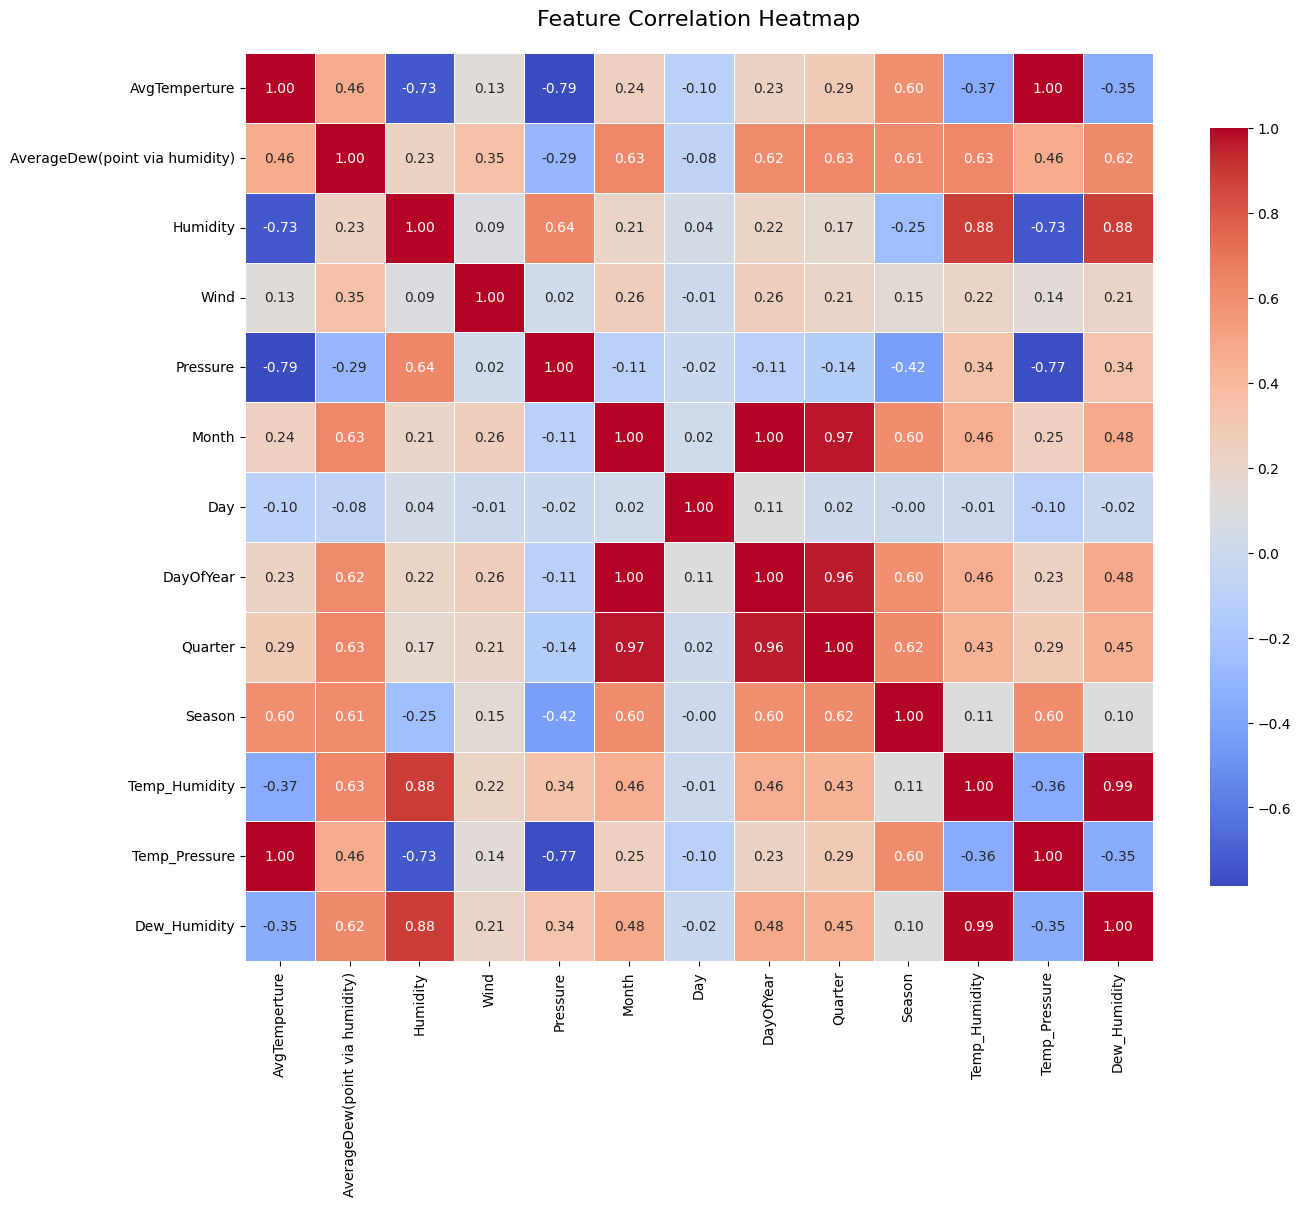

In [ ]:
print("\n--- Covariance Matrix ---")
cov_matrix = X.cov()
print(cov_matrix)

print("\n--- Correlation Matrix ---")
corr_matrix = X.corr()
print(corr_matrix)

# Correlation Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Heatmap", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*80)
print("5. STATISTICAL TESTS (Chi-square, t-test, ANOVA)")
print("="*80)

# Create categorical versions for Chi-square test
df['Temp_Category'] = pd.cut(df['AvgTemperture'], bins=3, labels=['Low', 'Medium', 'High'])
df['Humidity_Category'] = pd.cut(df['Humidity'], bins=3, labels=['Low', 'Medium', 'High'])

# --- Chi-Square Test ---
print("\n--- Chi-Square Test (Feature Independence) ---")
contingency_table = pd.crosstab(df['Temp_Category'], df['Power_Class'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nTemperature vs Power Class:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"Result: {'Dependent (Reject H0)' if p_value < 0.05 else 'Independent (Fail to reject H0)'}")

contingency_table2 = pd.crosstab(df['Humidity_Category'], df['Power_Class'])
chi2_2, p_value_2, dof_2, expected_2 = chi2_contingency(contingency_table2)
print(f"\nHumidity vs Power Class:")
print(f"Chi-square statistic: {chi2_2:.4f}")
print(f"P-value: {p_value_2:.4f}")
print(f"Result: {'Dependent (Reject H0)' if p_value_2 < 0.05 else 'Independent (Fail to reject H0)'}")

# --- T-Test ---
print("\n--- T-Test (Mean Differences Between Two Groups) ---")
low_power = df[df['Power_Class'] == 'Low']['AvgTemperture']
high_power = df[df['Power_Class'] == 'High']['AvgTemperture']

t_stat, t_pvalue = ttest_ind(low_power, high_power)
print(f"\nTemperature: Low vs High Power Class")
print(f"Low Power Mean: {low_power.mean():.4f}, High Power Mean: {high_power.mean():.4f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {t_pvalue:.4f}")
print(f"Result: {'Means are significantly different' if t_pvalue < 0.05 else 'No significant difference'}")

# --- ANOVA ---
print("\n--- ANOVA Test (Mean Differences Across All Classes) ---")
low_temps = df[df['Power_Class'] == 'Low']['AvgTemperture']
med_temps = df[df['Power_Class'] == 'Medium']['AvgTemperture']
high_temps = df[df['Power_Class'] == 'High']['AvgTemperture']

f_stat, anova_pvalue = f_oneway(low_temps, med_temps, high_temps)
print(f"\nTemperature across all Power Classes:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {anova_pvalue:.4f}")
print(f"Result: {'At least one mean is different' if anova_pvalue < 0.05 else 'All means are equal'}")


5. STATISTICAL TESTS (Chi-square, t-test, ANOVA)

--- Chi-Square Test (Feature Independence) ---

Temperature vs Power Class:
Chi-square statistic: 24.3659
P-value: 0.0001
Degrees of freedom: 4
Result: Dependent (Reject H0)

Humidity vs Power Class:
Chi-square statistic: 19.2140
P-value: 0.0007
Result: Dependent (Reject H0)

--- T-Test (Mean Differences Between Two Groups) ---

Temperature: Low vs High Power Class
Low Power Mean: 82.0639, High Power Mean: 83.8853
T-statistic: -1.0892
P-value: 0.2771
Result: No significant difference

--- ANOVA Test (Mean Differences Across All Classes) ---

Temperature across all Power Classes:
F-statistic: 3.3896
P-value: 0.0347
Result: At least one mean is different



6. DATA VISUALIZATION


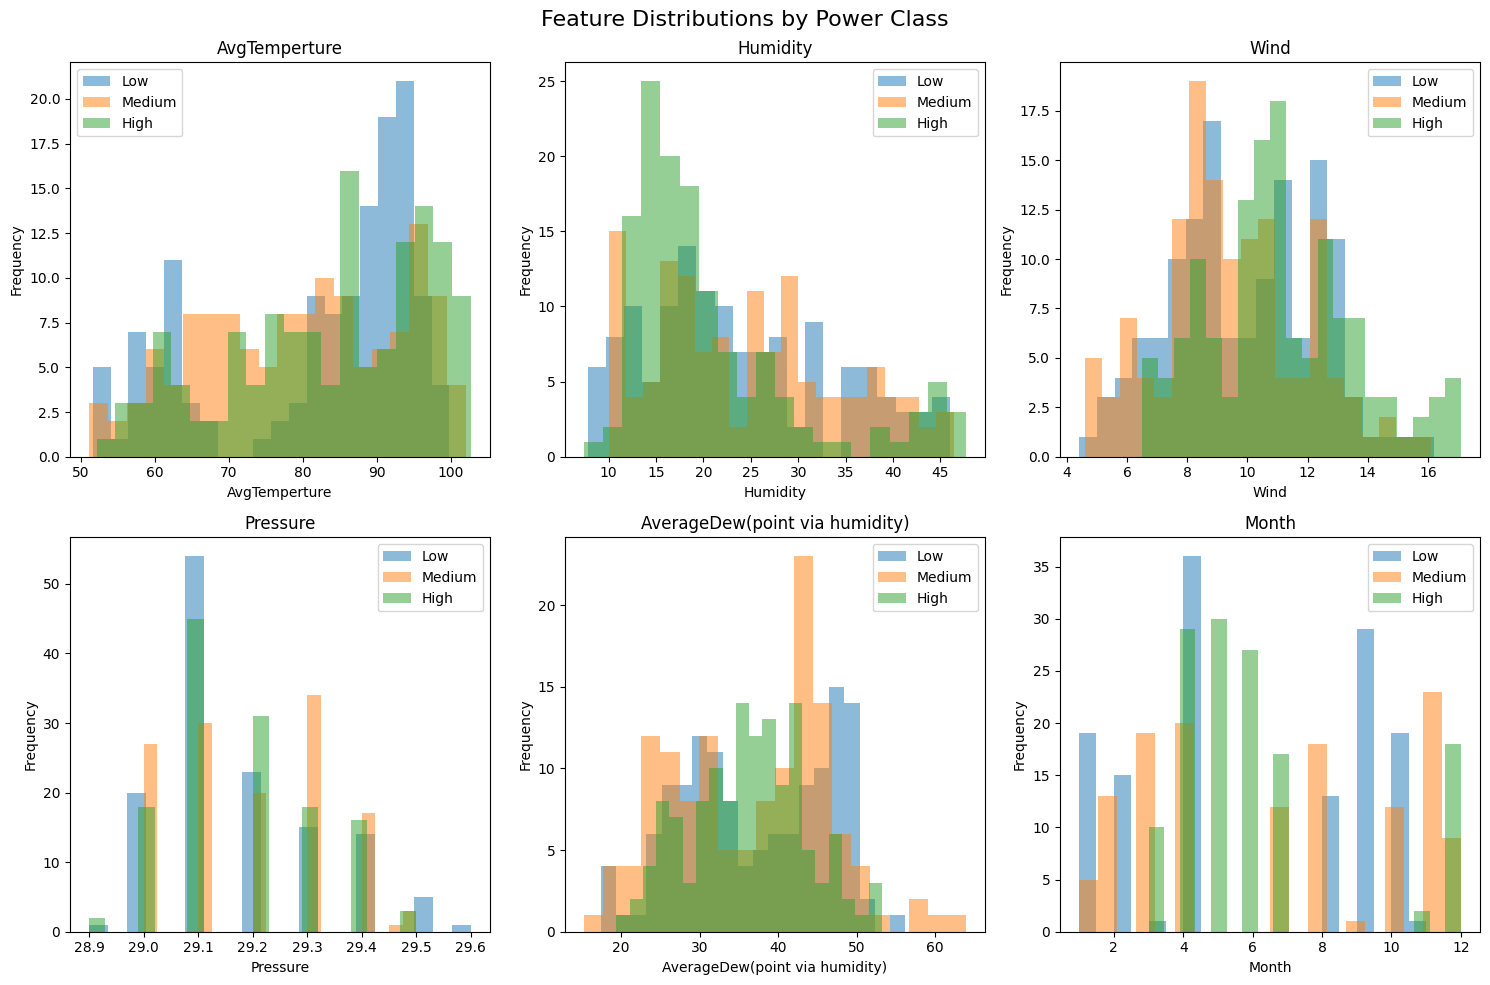

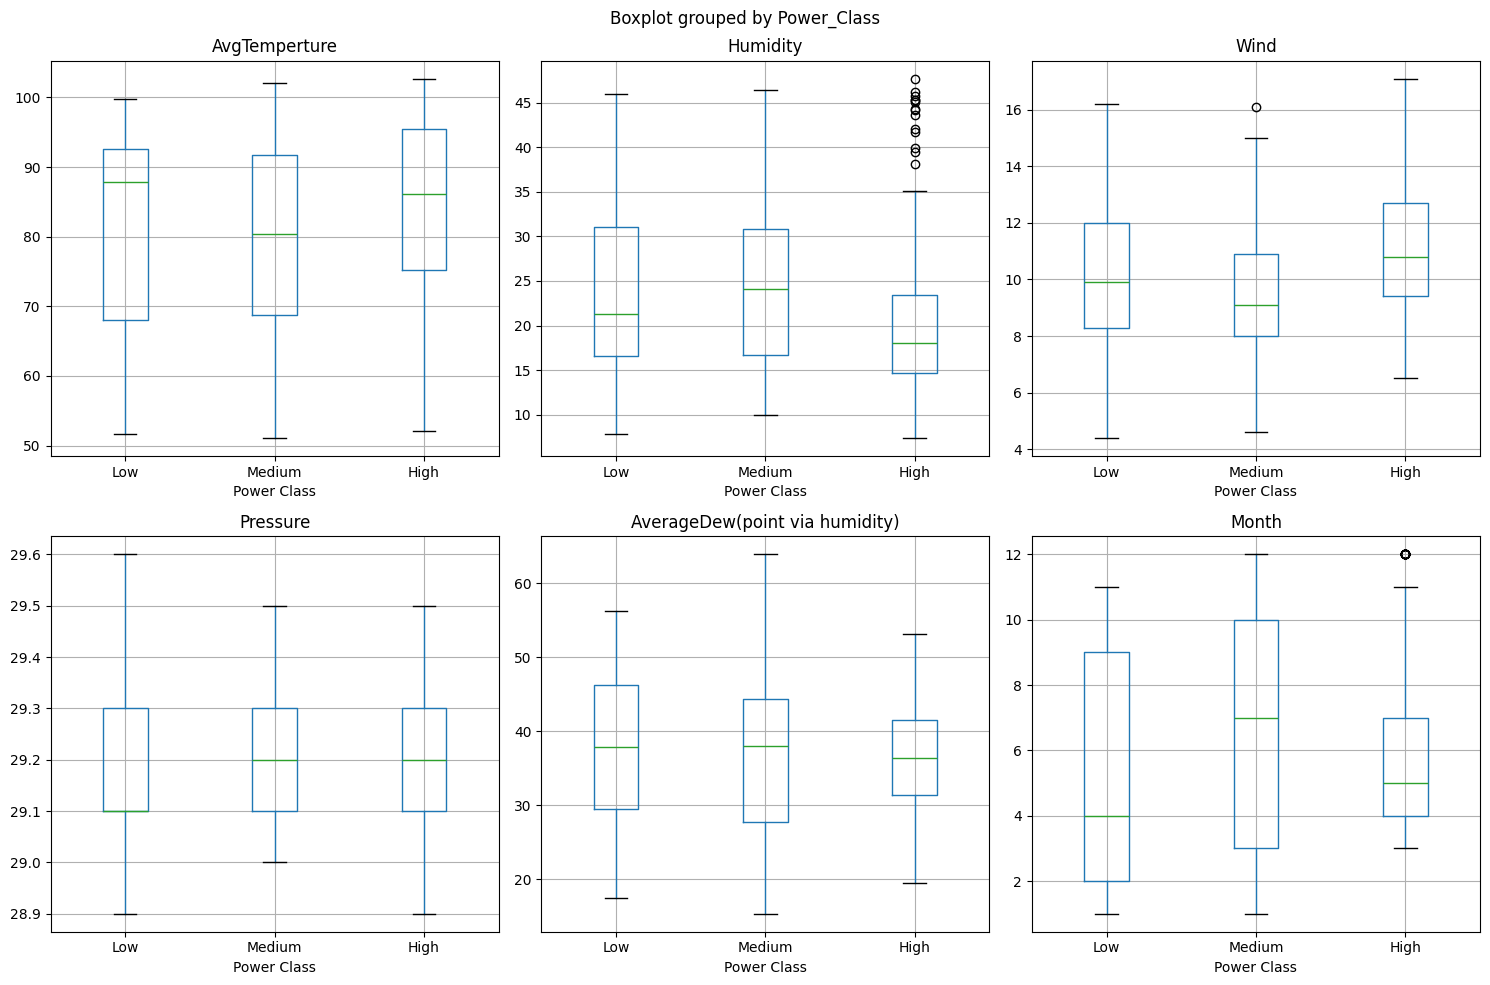

In [ ]:
print("\n" + "="*80)
print("6. DATA VISUALIZATION")
print("="*80)

# Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Feature Distributions by Power Class', fontsize=16)

features_to_plot = ['AvgTemperture', 'Humidity', 'Wind', 'Pressure', 'AverageDew(point via humidity)', 'Month']
for idx, feature in enumerate(features_to_plot):
    row = idx // 3
    col = idx % 3
    for power_class in ['Low', 'Medium', 'High']:
        data = df[df['Power_Class'] == power_class][feature]
        axes[row, col].hist(data, alpha=0.5, label=power_class, bins=20)
    axes[row, col].set_title(feature)
    axes[row, col].legend()
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Box plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Box Plots: Features by Power Class', fontsize=16)

for idx, feature in enumerate(features_to_plot):
    row = idx // 3
    col = idx % 3
    df.boxplot(column=feature, by='Power_Class', ax=axes[row, col])
    axes[row, col].set_title(feature)
    axes[row, col].set_xlabel('Power Class')

plt.tight_layout()
plt.show()


7. FEATURE REDUCTION - PCA & LDA

--- Principal Component Analysis (PCA) ---
Explained Variance Ratio: [0.38582269 0.33584573]
Total Variance Explained: 0.7217

--- Linear Discriminant Analysis (LDA) ---
Explained Variance Ratio: [0.84579133 0.15420867]


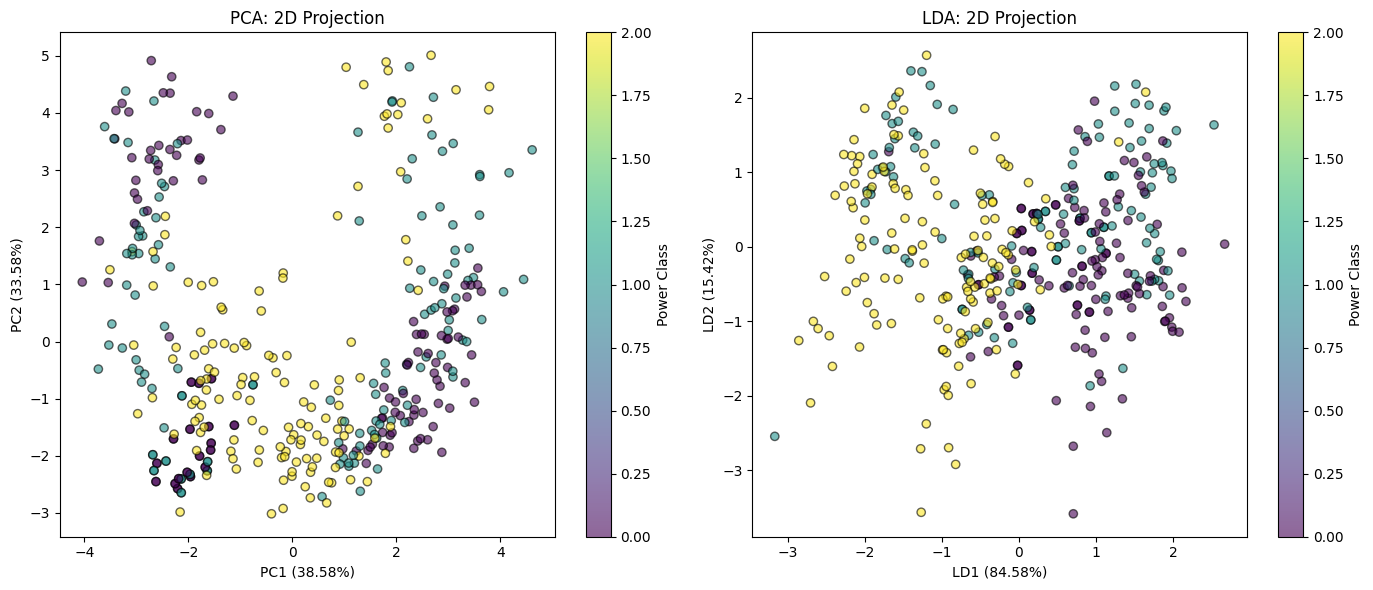

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

# ========================================
# 7. FEATURE REDUCTION (PCA & LDA)
# ========================================
print("\n" + "="*80)
print("7. FEATURE REDUCTION - PCA & LDA")
print("="*80)

# Scale data (mandatory for PCA/LDA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- PCA ---
print("\n--- Principal Component Analysis (PCA) ---")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Variance Explained: {sum(pca.explained_variance_ratio_):.4f}")

# --- LDA ---
print("\n--- Linear Discriminant Analysis (LDA) ---")
lda_reducer = LDA(n_components=2)
X_lda = lda_reducer.fit_transform(X_scaled, y)
print(f"Explained Variance Ratio: {lda_reducer.explained_variance_ratio_}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PCA Plot
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y.astype('category').cat.codes,
                           cmap='viridis', alpha=0.6, edgecolors='k')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[0].set_title('PCA: 2D Projection')
plt.colorbar(scatter1, ax=axes[0], label='Power Class')

# LDA Plot
scatter2 = axes[1].scatter(X_lda[:, 0], X_lda[:, 1], c=y.astype('category').cat.codes,
                           cmap='viridis', alpha=0.6, edgecolors='k')
axes[1].set_xlabel(f'LD1 ({lda_reducer.explained_variance_ratio_[0]:.2%})')
axes[1].set_ylabel(f'LD2 ({lda_reducer.explained_variance_ratio_[1]:.2%})')
axes[1].set_title('LDA: 2D Projection')
plt.colorbar(scatter2, ax=axes[1], label='Power Class')

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*80)
print("8. DATA SPLITTING (80% Train, 20% Test)")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nClass distribution in train set:")
print(y_train.value_counts())
print(f"\nClass distribution in test set:")
print(y_test.value_counts())


8. DATA SPLITTING (80% Train, 20% Test)
Training set: 318 samples
Test set: 80 samples

Class distribution in train set:
Power_Class
Low       106
Medium    106
High      106
Name: count, dtype: int64

Class distribution in test set:
Power_Class
Low       27
High      27
Medium    26
Name: count, dtype: int64


In [ ]:
print("\n" + "="*80)
print("9. MODEL IMPLEMENTATIONS")
print("="*80)

# Initialize base models
base_models = {
    "Naive Bayes": GaussianNB(),
    "Decision Tree (Entropy)": DecisionTreeClassifier(criterion='entropy', random_state=42),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=7),
}

# Train and evaluate base models
print("\n--- Base Models Performance ---")
results = {}
train_scores = {}

for name, model in base_models.items():
    # Train
    model.fit(X_train, y_train)

    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    results[name] = {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'error_rate': 1 - test_acc,
        'model': model,
        'predictions': y_test_pred
    }

    print(f"\n--- {name} ---")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Error Rate: {1 - test_acc:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))


9. MODEL IMPLEMENTATIONS

--- Base Models Performance ---

--- Naive Bayes ---
Training Accuracy: 0.5157
Test Accuracy: 0.3750
Error Rate: 0.6250

Confusion Matrix:
[[19  3  5]
 [14  5  8]
 [15  5  6]]

Classification Report:
              precision    recall  f1-score   support

        High       0.40      0.70      0.51        27
         Low       0.38      0.19      0.25        27
      Medium       0.32      0.23      0.27        26

    accuracy                           0.38        80
   macro avg       0.37      0.37      0.34        80
weighted avg       0.37      0.38      0.34        80


--- Decision Tree (Entropy) ---
Training Accuracy: 1.0000
Test Accuracy: 0.8250
Error Rate: 0.1750

Confusion Matrix:
[[23  0  4]
 [ 0 23  4]
 [ 1  5 20]]

Classification Report:
              precision    recall  f1-score   support

        High       0.96      0.85      0.90        27
         Low       0.82      0.85      0.84        27
      Medium       0.71      0.77      0.74      


10. DECISION TREE - ERROR ESTIMATION

--- Tree Complexity Metrics ---
Number of Leaves: 51
Tree Depth: 10
Number of Features Used: 11

--- Feature Importance ---
                           Feature  Importance
7                        DayOfYear    0.480852
2                         Humidity    0.114574
9                           Season    0.085273
10                   Temp_Humidity    0.077056
0                    AvgTemperture    0.070679
6                              Day    0.045507
3                             Wind    0.042977
1   AverageDew(point via humidity)    0.029151
12                    Dew_Humidity    0.020039
4                         Pressure    0.019967
11                   Temp_Pressure    0.013927
8                          Quarter    0.000000
5                            Month    0.000000

--- Error Estimation ---
Apparent Error (Test Set): 0.1750
Pessimistic Error Estimate: 0.4938


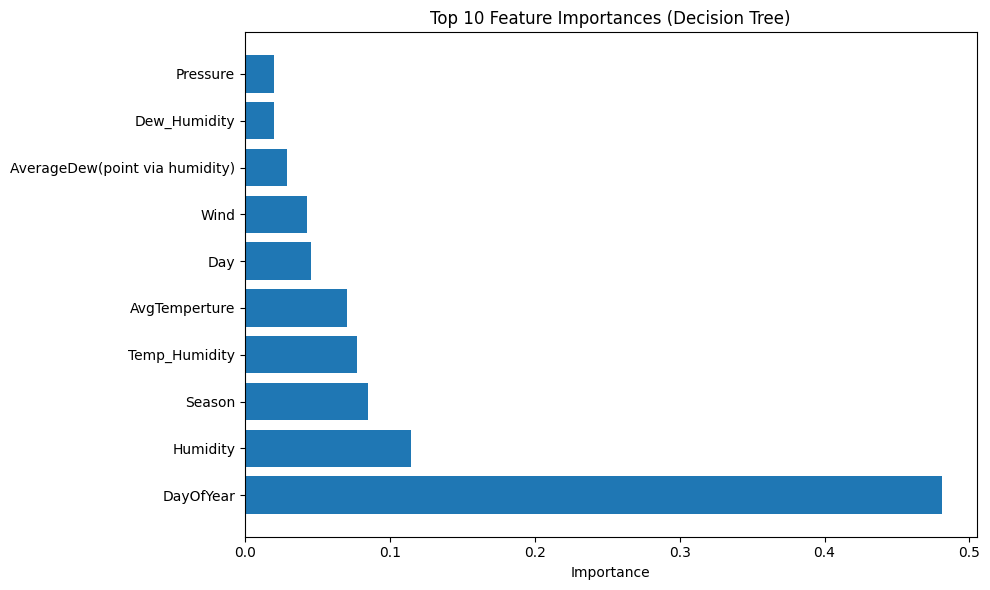

In [ ]:
print("\n" + "="*80)
print("10. DECISION TREE - ERROR ESTIMATION")
print("="*80)

dt_model = results["Decision Tree (Entropy)"]['model']

print("\n--- Tree Complexity Metrics ---")
print(f"Number of Leaves: {dt_model.get_n_leaves()}")
print(f"Tree Depth: {dt_model.get_depth()}")
print(f"Number of Features Used: {np.sum(dt_model.feature_importances_ > 0)}")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n--- Feature Importance ---")
print(feature_importance)

# Pessimistic Error Estimation
n_leaves = dt_model.get_n_leaves()
n_test = len(y_test)
error_count = np.sum(y_test != results["Decision Tree (Entropy)"]['predictions'])
pessimistic_error = (error_count + 0.5 * n_leaves) / n_test

print(f"\n--- Error Estimation ---")
print(f"Apparent Error (Test Set): {error_count / n_test:.4f}")
print(f"Pessimistic Error Estimate: {pessimistic_error:.4f}")

# Visualize Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Decision Tree)')
plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*80)
print("11. HYPERPARAMETER TUNING")
print("="*80)

# Decision Tree tuning
print("\n--- Tuning Decision Tree ---")
dt_params = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['entropy', 'gini']
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
dt_grid.fit(X_train, y_train)

print(f"Best Parameters: {dt_grid.best_params_}")
print(f"Best CV Score: {dt_grid.best_score_:.4f}")

# KNN tuning
print("\n--- Tuning KNN ---")
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    knn_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
knn_grid.fit(X_train, y_train)

print(f"Best Parameters: {knn_grid.best_params_}")
print(f"Best CV Score: {knn_grid.best_score_:.4f}")


11. HYPERPARAMETER TUNING

--- Tuning Decision Tree ---
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best CV Score: 0.7862

--- Tuning KNN ---
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best CV Score: 0.7925


In [ ]:
print("\n" + "="*80)
print("12. ADVANCED MODELS")
print("="*80)

advanced_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
    'Decision Tree (Tuned)': dt_grid.best_estimator_,
    'KNN (Tuned)': knn_grid.best_estimator_
}

print("\n--- Training Advanced Models ---")
for name, model in advanced_models.items():
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    results[name] = {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'error_rate': 1 - test_acc,
        'model': model,
        'predictions': y_test_pred
    }

    print(f"\n{name}:")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Error Rate: {1 - test_acc:.4f}")


12. ADVANCED MODELS

--- Training Advanced Models ---

Random Forest:
  Train Accuracy: 1.0000
  Test Accuracy: 0.8125
  Error Rate: 0.1875

Gradient Boosting:
  Train Accuracy: 1.0000
  Test Accuracy: 0.8250
  Error Rate: 0.1750

SVM (RBF):
  Train Accuracy: 0.7484
  Test Accuracy: 0.6875
  Error Rate: 0.3125

Decision Tree (Tuned):
  Train Accuracy: 0.9057
  Test Accuracy: 0.7625
  Error Rate: 0.2375

KNN (Tuned):
  Train Accuracy: 1.0000
  Test Accuracy: 0.7500
  Error Rate: 0.2500


In [ ]:
print("\n" + "="*80)
print("13. LDA AS CLASSIFIER")
print("="*80)

lda_classifier = LDA()
lda_classifier.fit(X_train, y_train)

y_train_pred_lda = lda_classifier.predict(X_train)
y_test_pred_lda = lda_classifier.predict(X_test)

train_acc_lda = accuracy_score(y_train, y_train_pred_lda)
test_acc_lda = accuracy_score(y_test, y_test_pred_lda)

results['LDA Classifier'] = {
    'train_accuracy': train_acc_lda,
    'test_accuracy': test_acc_lda,
    'error_rate': 1 - test_acc_lda,
    'model': lda_classifier,
    'predictions': y_test_pred_lda
}

print(f"Training Accuracy: {train_acc_lda:.4f}")
print(f"Test Accuracy: {test_acc_lda:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_lda))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_lda))


13. LDA AS CLASSIFIER
Training Accuracy: 0.6289
Test Accuracy: 0.5625

Confusion Matrix:
[[21  1  5]
 [ 4 15  8]
 [ 9  8  9]]

Classification Report:
              precision    recall  f1-score   support

        High       0.62      0.78      0.69        27
         Low       0.62      0.56      0.59        27
      Medium       0.41      0.35      0.38        26

    accuracy                           0.56        80
   macro avg       0.55      0.56      0.55        80
weighted avg       0.55      0.56      0.55        80



In [ ]:
print("\n" + "="*80)
print("14. PCA-BASED CLASSIFICATION")
print("="*80)

for n_comp in [2, 3, 5]:
    print(f"\n--- Using {n_comp} PCA Components ---")

    pca_temp = PCA(n_components=n_comp)
    X_train_pca = pca_temp.fit_transform(X_train)
    X_test_pca = pca_temp.transform(X_test)

    print(f"Variance Explained: {sum(pca_temp.explained_variance_ratio_):.4f}")

    # Train classifier on PCA features
    rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_pca.fit(X_train_pca, y_train)

    y_test_pred_pca = rf_pca.predict(X_test_pca)
    test_acc_pca = accuracy_score(y_test, y_test_pred_pca)

    results[f'PCA-{n_comp} + RF'] = {
        'train_accuracy': rf_pca.score(X_train_pca, y_train),
        'test_accuracy': test_acc_pca,
        'error_rate': 1 - test_acc_pca,
        'model': rf_pca,
        'predictions': y_test_pred_pca
    }

    print(f"Test Accuracy: {test_acc_pca:.4f}")


14. PCA-BASED CLASSIFICATION

--- Using 2 PCA Components ---
Variance Explained: 0.7247
Test Accuracy: 0.6500

--- Using 3 PCA Components ---
Variance Explained: 0.8149
Test Accuracy: 0.7250

--- Using 5 PCA Components ---
Variance Explained: 0.9471
Test Accuracy: 0.7375


In [ ]:
print("\n" + "="*80)
print("15. K-FOLD CROSS VALIDATION (10-Fold)")
print("="*80)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print("\n--- Cross-Validation Scores ---")
cv_results = {}

for name, result_dict in results.items():
    if 'PCA' not in name:  # Skip PCA models for simplicity
        model = result_dict['model']
        scores = cross_val_score(model, X_scaled, y, cv=skf, scoring='accuracy')
        cv_results[name] = scores
        print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")



15. K-FOLD CROSS VALIDATION (10-Fold)

--- Cross-Validation Scores ---
Naive Bayes: 0.4973 (+/- 0.0809)
Decision Tree (Entropy): 0.7865 (+/- 0.0572)
KNN (k=5): 0.7464 (+/- 0.0672)
KNN (k=7): 0.7012 (+/- 0.0628)
Random Forest: 0.8418 (+/- 0.0526)
Gradient Boosting: 0.8267 (+/- 0.0466)
SVM (RBF): 0.6835 (+/- 0.0778)
Decision Tree (Tuned): 0.7817 (+/- 0.0493)
KNN (Tuned): 0.7939 (+/- 0.0769)
LDA Classifier: 0.5752 (+/- 0.0796)



16. ROC CURVES (One-vs-Rest)


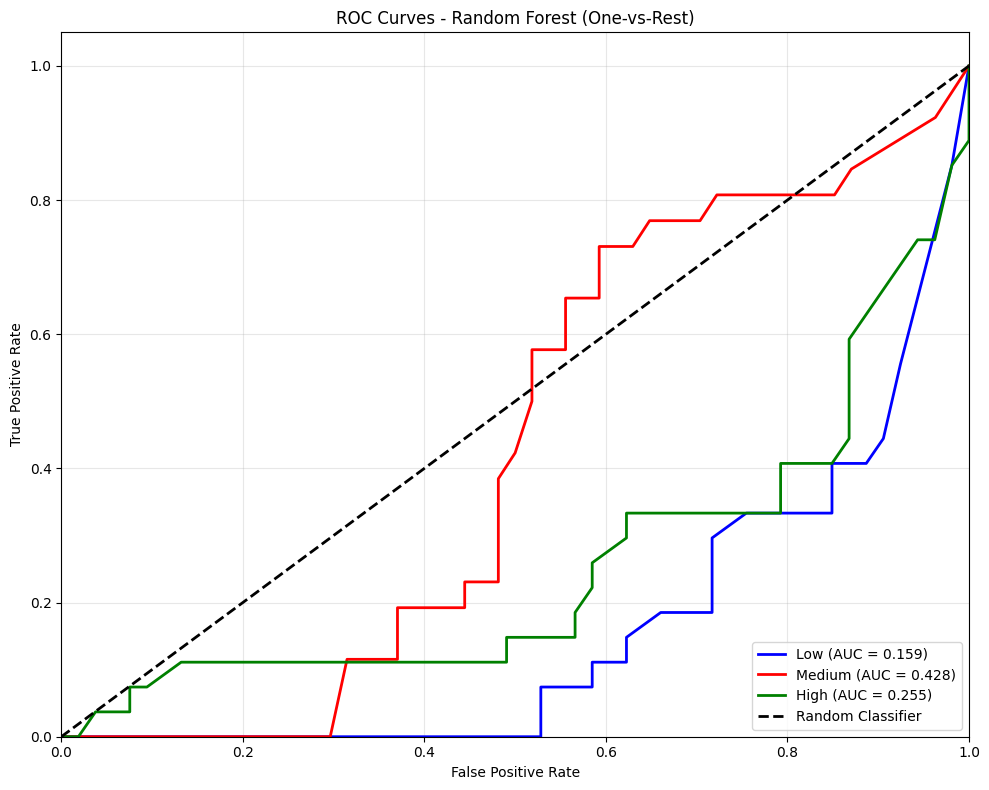


--- AUC Scores ---
Low: 0.1586
Medium: 0.4277
High: 0.2554

--- FROC (Free-Response ROC) ---
Note: FROC is typically used for detection tasks (e.g., medical imaging).
For classification tasks, standard ROC curves (shown above) are appropriate.


In [ ]:
print("\n" + "="*80)
print("16. ROC CURVES (One-vs-Rest)")
print("="*80)

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=['Low', 'Medium', 'High'])
n_classes = y_test_bin.shape[1]

# Use Random Forest for ROC (best performing model)
rf_model = results['Random Forest']['model']
if hasattr(rf_model, 'predict_proba'):
    y_score = rf_model.predict_proba(X_test)

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green']
    class_names = ['Low', 'Medium', 'High']

    for i, color, class_name in zip(range(n_classes), colors, class_names):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_name} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Random Forest (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n--- AUC Scores ---")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {roc_auc[i]:.4f}")

    print("\n--- FROC (Free-Response ROC) ---")
    print("Note: FROC is typically used for detection tasks (e.g., medical imaging).")
    print("For classification tasks, standard ROC curves (shown above) are appropriate.")



17. OVERFITTING/UNDERFITTING ANALYSIS

--- Model Fitting Analysis ---

Model: Naive Bayes
Status: UNDERFITTING
Explanation: Both train and test accuracy are low. Model is too simple.
Recommendation: Try: more complex models, more features, reduce regularization

Model: Decision Tree (Entropy)
Status: OVERFITTING
Explanation: Train accuracy (1.000) >> Test accuracy (0.825)
Recommendation: Try: regularization, fewer features, simpler model, more data

Model: KNN (k=5)
Status: SLIGHT OVERFITTING
Explanation: Small gap between train (0.827) and test (0.688)
Recommendation: Model is acceptable but could be improved with light regularization

Model: KNN (k=7)
Status: SLIGHT OVERFITTING
Explanation: Small gap between train (0.780) and test (0.675)
Recommendation: Model is acceptable but could be improved with light regularization

Model: Random Forest
Status: OVERFITTING
Explanation: Train accuracy (1.000) >> Test accuracy (0.812)
Recommendation: Try: regularization, fewer features, simpler 

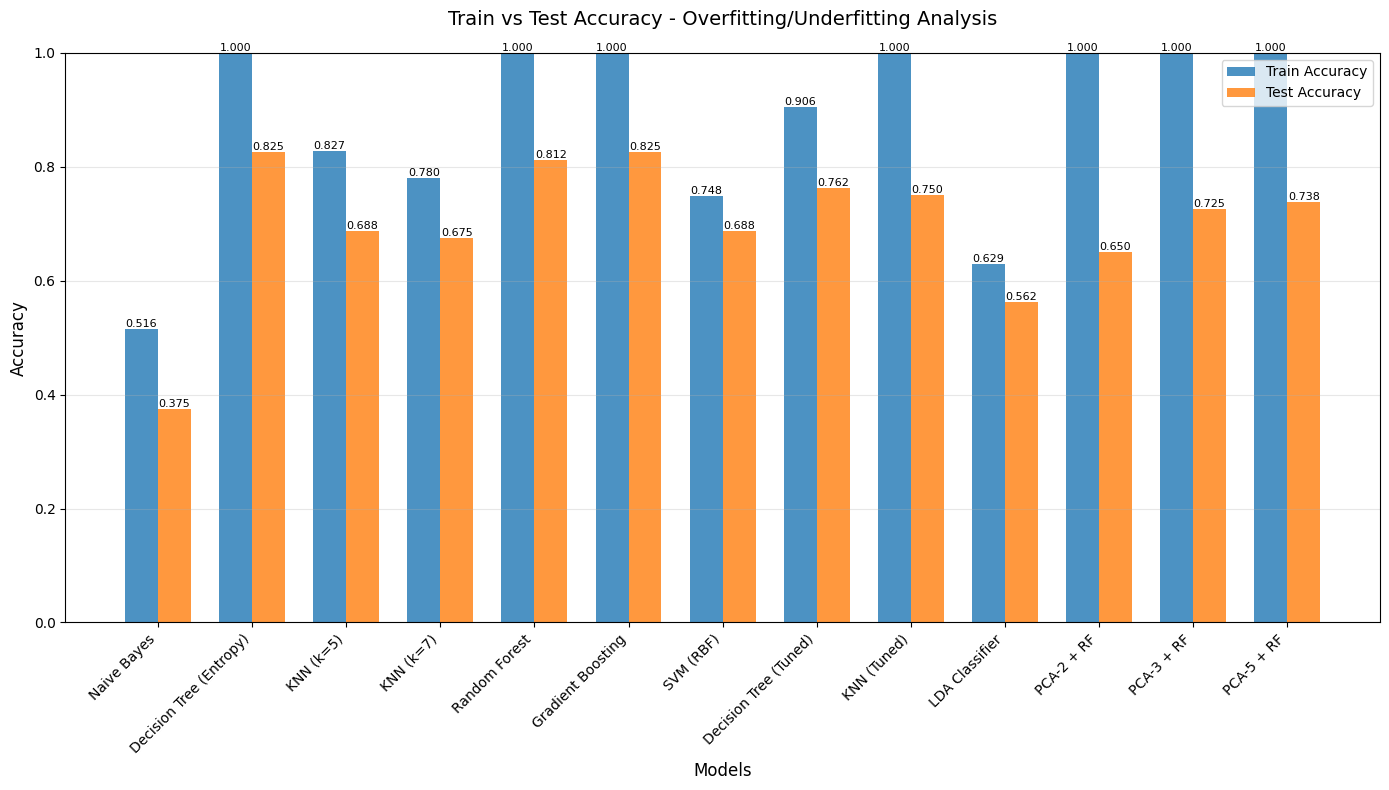

In [ ]:
print("\n" + "="*80)
print("17. OVERFITTING/UNDERFITTING ANALYSIS")
print("="*80)

def analyze_fitting(train_acc, test_acc, model_name):
    """Analyze if model is overfitting, underfitting, or good fit"""
    diff = train_acc - test_acc

    if train_acc < 0.70 and test_acc < 0.70:
        status = "UNDERFITTING"
        explanation = "Both train and test accuracy are low. Model is too simple."
        solution = "Try: more complex models, more features, reduce regularization"
    elif diff > 0.15:
        status = "OVERFITTING"
        explanation = f"Train accuracy ({train_acc:.3f}) >> Test accuracy ({test_acc:.3f})"
        solution = "Try: regularization, fewer features, simpler model, more data"
    elif diff > 0.05:
        status = "SLIGHT OVERFITTING"
        explanation = f"Small gap between train ({train_acc:.3f}) and test ({test_acc:.3f})"
        solution = "Model is acceptable but could be improved with light regularization"
    else:
        status = "GOOD FIT"
        explanation = f"Train ({train_acc:.3f}) and test ({test_acc:.3f}) are close"
        solution = "Model generalizes well!"

    return status, explanation, solution

print("\n--- Model Fitting Analysis ---\n")
fitting_results = []

for name, result_dict in results.items():
    train_acc = result_dict['train_accuracy']
    test_acc = result_dict['test_accuracy']

    status, explanation, solution = analyze_fitting(train_acc, test_acc, name)

    fitting_results.append({
        'Model': name,
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'Status': status
    })

    print(f"{'='*70}")
    print(f"Model: {name}")
    print(f"Status: {status}")
    print(f"Explanation: {explanation}")
    print(f"Recommendation: {solution}")
    print()

# Visualization
fitting_df = pd.DataFrame(fitting_results)
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(fitting_df))
width = 0.35

bars1 = ax.bar(x - width/2, fitting_df['Train Acc'], width, label='Train Accuracy', alpha=0.8)
bars2 = ax.bar(x + width/2, fitting_df['Test Acc'], width, label='Test Accuracy', alpha=0.8)

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Train vs Test Accuracy - Overfitting/Underfitting Analysis', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(fitting_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*80)
print("18. COMPREHENSIVE RESULTS SUMMARY")
print("="*80)

summary_data = []
for name, result_dict in results.items():
    summary_data.append({
        'Model': name,
        'Train Accuracy': f"{result_dict['train_accuracy']:.4f}",
        'Test Accuracy': f"{result_dict['test_accuracy']:.4f}",
        'Error Rate': f"{result_dict['error_rate']:.4f}",
        'Fitting Status': fitting_results[[i['Model'] for i in fitting_results].index(name)]['Status']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Test Accuracy', ascending=False)

print("\n" + summary_df.to_string(index=False))


18. COMPREHENSIVE RESULTS SUMMARY

                  Model Train Accuracy Test Accuracy Error Rate     Fitting Status
Decision Tree (Entropy)         1.0000        0.8250     0.1750        OVERFITTING
      Gradient Boosting         1.0000        0.8250     0.1750        OVERFITTING
          Random Forest         1.0000        0.8125     0.1875        OVERFITTING
  Decision Tree (Tuned)         0.9057        0.7625     0.2375 SLIGHT OVERFITTING
            KNN (Tuned)         1.0000        0.7500     0.2500        OVERFITTING
             PCA-5 + RF         1.0000        0.7375     0.2625        OVERFITTING
             PCA-3 + RF         1.0000        0.7250     0.2750        OVERFITTING
              KNN (k=5)         0.8270        0.6875     0.3125 SLIGHT OVERFITTING
              SVM (RBF)         0.7484        0.6875     0.3125 SLIGHT OVERFITTING
              KNN (k=7)         0.7799        0.6750     0.3250 SLIGHT OVERFITTING
             PCA-2 + RF         1.0000        0.650


19. SINGULAR VALUE DECOMPOSITION (SVD)
Explained Variance Ratio (SVD): [0.38582269 0.33584573]
Total Variance Explained: 0.7217


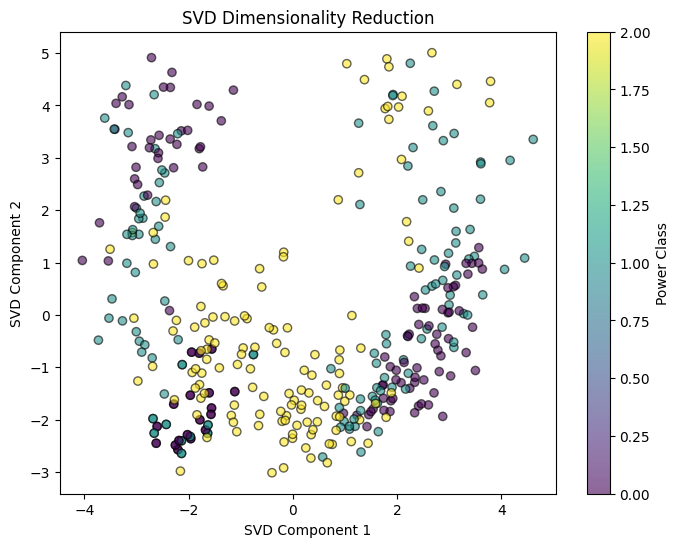

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ========================================
# 19. SINGULAR VALUE DECOMPOSITION (SVD)
# ========================================
print("\n" + "="*80)
print("19. SINGULAR VALUE DECOMPOSITION (SVD)")
print("="*80)

# --- SVD Implementation ---
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X_scaled)

print("Explained Variance Ratio (SVD):", svd.explained_variance_ratio_)
print(f"Total Variance Explained: {sum(svd.explained_variance_ratio_):.4f}")

# Visualize SVD
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y.astype('category').cat.codes, cmap='viridis', alpha=0.6, edgecolors='k')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.title('SVD Dimensionality Reduction')
plt.colorbar(scatter, label='Power Class')
plt.show()


20. LINEAR REGRESSION (Predicting Continuous Solar Power)
R-squared Score: 0.2648
Mean Squared Error (MSE): 40.2925
Mean Absolute Error (MAE): 5.3785


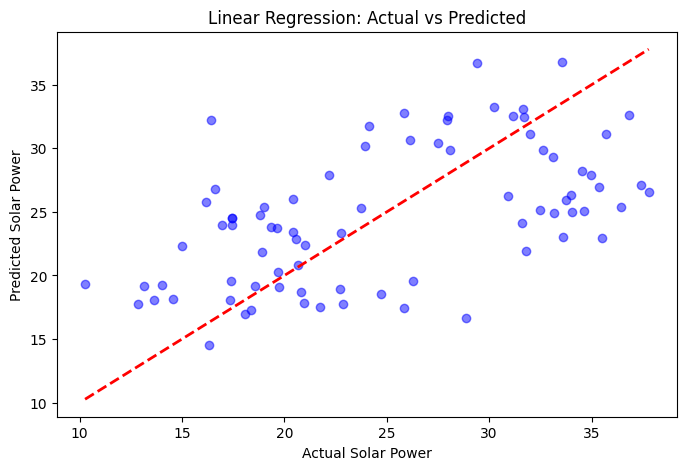

In [ ]:
# ========================================
# 20. LINEAR REGRESSION (Continuous Target)
# ========================================
print("\n" + "="*80)
print("20. LINEAR REGRESSION (Predicting Continuous Solar Power)")
print("="*80)

# 1. Prepare Data for Regression (Continuous Target)
# We need the continuous 'Solar(PV)' column, not the classes
y_reg = df['Solar(PV)']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_scaled, y_reg, test_size=0.2, random_state=42
)

# 2. Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_reg, y_train_reg)

# 3. Predict & Evaluate
y_pred_reg = lr_model.predict(X_test_reg)

print(f"R-squared Score: {r2_score(y_test_reg, y_pred_reg):.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test_reg, y_pred_reg):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test_reg, y_pred_reg):.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_test_reg, y_pred_reg, color='blue', alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Actual Solar Power')
plt.ylabel('Predicted Solar Power')
plt.title('Linear Regression: Actual vs Predicted')
plt.show()

In [ ]:
# ========================================
# 21. LOGISTIC REGRESSION (Classification)
# ========================================
print("\n" + "="*80)
print("21. LOGISTIC REGRESSION (Classification)")
print("="*80)

# Train Logistic Regression on original classification task (Low/Medium/High)
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_log))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log))


21. LOGISTIC REGRESSION (Classification)
Logistic Regression Accuracy: 0.4625

Confusion Matrix:
[[15  8  4]
 [ 9  9  9]
 [ 9  4 13]]

Classification Report:
              precision    recall  f1-score   support

        High       0.45      0.56      0.50        27
         Low       0.43      0.33      0.38        27
      Medium       0.50      0.50      0.50        26

    accuracy                           0.46        80
   macro avg       0.46      0.46      0.46        80
weighted avg       0.46      0.46      0.46        80




22. NEURAL NETWORKS (Feed Forward)

--- A. Feed Forward Neural Network (Classification) ---
MLP Classifier Accuracy: 0.7625

Classification Report (NN):
              precision    recall  f1-score   support

        High       0.85      0.85      0.85        27
         Low       0.72      0.78      0.75        27
      Medium       0.71      0.65      0.68        26

    accuracy                           0.76        80
   macro avg       0.76      0.76      0.76        80
weighted avg       0.76      0.76      0.76        80


--- B. Feed Forward Neural Network (Regression) ---
MLP Regressor R2 Score: 0.5241
MLP Regressor MSE: 26.0821


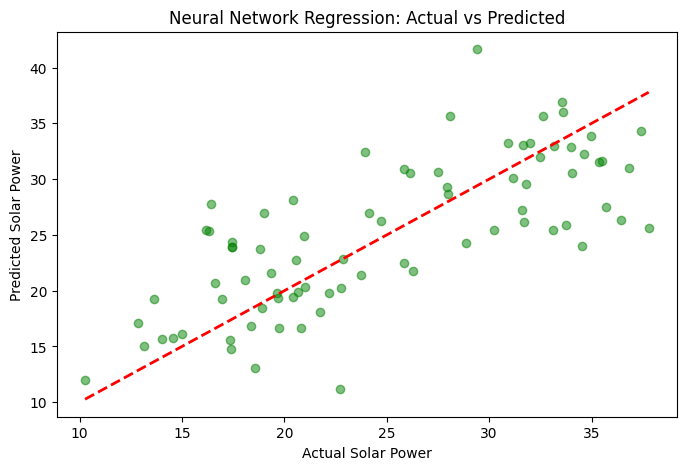

In [ ]:
# ========================================
# 22. NEURAL NETWORKS (MLP)
# ========================================
print("\n" + "="*80)
print("22. NEURAL NETWORKS (Feed Forward)")
print("="*80)

# --- A. Feed Forward Neural Network (Classification) ---
print("\n--- A. Feed Forward Neural Network (Classification) ---")
# MLPClassifier for categorical target
mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                        max_iter=500, random_state=42)
mlp_clf.fit(X_train, y_train)
y_pred_mlp_clf = mlp_clf.predict(X_test)

print(f"MLP Classifier Accuracy: {accuracy_score(y_test, y_pred_mlp_clf):.4f}")
print("\nClassification Report (NN):")
print(classification_report(y_test, y_pred_mlp_clf))

# --- B. Feed Forward Neural Network (Regression) ---
print("\n--- B. Feed Forward Neural Network (Regression) ---")
# MLPRegressor for continuous target
mlp_reg = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                       max_iter=500, random_state=42)
mlp_reg.fit(X_train_reg, y_train_reg)
y_pred_mlp_reg = mlp_reg.predict(X_test_reg)

print(f"MLP Regressor R2 Score: {r2_score(y_test_reg, y_pred_mlp_reg):.4f}")
print(f"MLP Regressor MSE: {mean_squared_error(y_test_reg, y_pred_mlp_reg):.4f}")

# Plot Neural Network Regression Results
plt.figure(figsize=(8, 5))
plt.scatter(y_test_reg, y_pred_mlp_reg, color='green', alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Actual Solar Power')
plt.ylabel('Predicted Solar Power')
plt.title('Neural Network Regression: Actual vs Predicted')
plt.show()